In [2]:
!pip install -q kaggle

import os
import shutil
kaggle_json_path = '/content/kaggle.json'
if os.path.exists(kaggle_json_path):
    os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
    os.system(f'cp {kaggle_json_path} ~/.kaggle/')
    os.system('chmod 600 ~/.kaggle/kaggle.json')

!kaggle datasets download -d sovitrath/diabetic-retinopathy-224x224-gaussian-filtered -p /content/diabetic-retinopathy-dataset-esma --unzip

base_dir = '/content/diabetic-retinopathy-dataset-esma/gaussian_filtered_images/gaussian_filtered_images'
target_dir = '/content/all_images'

os.makedirs(target_dir, exist_ok=True)

subfolders = ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

for subfolder in subfolders:
    subfolder_path = os.path.join(base_dir, subfolder)
    if os.path.exists(subfolder_path):
        for file_name in os.listdir(subfolder_path):
            file_path = os.path.join(subfolder_path, file_name)
            if os.path.isfile(file_path):
                shutil.move(file_path, target_dir)

print(f"All images have been moved to {target_dir}")

Dataset URL: https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-224x224-gaussian-filtered
License(s): CC0-1.0
100% 426M/427M [00:21<00:00, 24.6MB/s]
100% 427M/427M [00:21<00:00, 21.2MB/s]
All images have been moved to /content/all_images


Found 2965 validated image filenames belonging to 5 classes.
Found 330 validated image filenames belonging to 5 classes.
Found 367 validated image filenames belonging to 5 classes.
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 243s 1s/step - accuracy: 0.5431 - loss: 1.1456 - val_accuracy: 0.0515 - val_loss: 1.6562 - learning_rate: 1.0000e-04
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 35s 346ms/step - accuracy: 0.7439 - loss: 0.6810 - val_accuracy: 0.4939 - val_loss: 1.3830 - learning_rate: 1.0000e-04
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 35s 347ms/step - accuracy: 0.7788 - loss: 0.6072 - val_accuracy: 0.4788 - val_loss: 1.3508 - learning_rate: 1.0000e-04
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 35s 346ms/step - accuracy: 0.7896 - loss: 0.5798 - val_accuracy: 0.5030 - val_loss: 1.2227 - learning_rate: 1.0000e-04
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 35s 348ms/step - accuracy: 0.8099 - loss: 0.5181 - val_accuracy: 0.6303 - val_loss: 1.0121 - learning_rate: 1.0000e-04
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 35s 349ms/step - accuracy: 0.8073 - loss: 0.4845 - val_accuracy: 0.6848 - val_loss: 0.8354 - learning_rate: 1.0000e-04
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 35s 348ms/step - accuracy: 0.8302

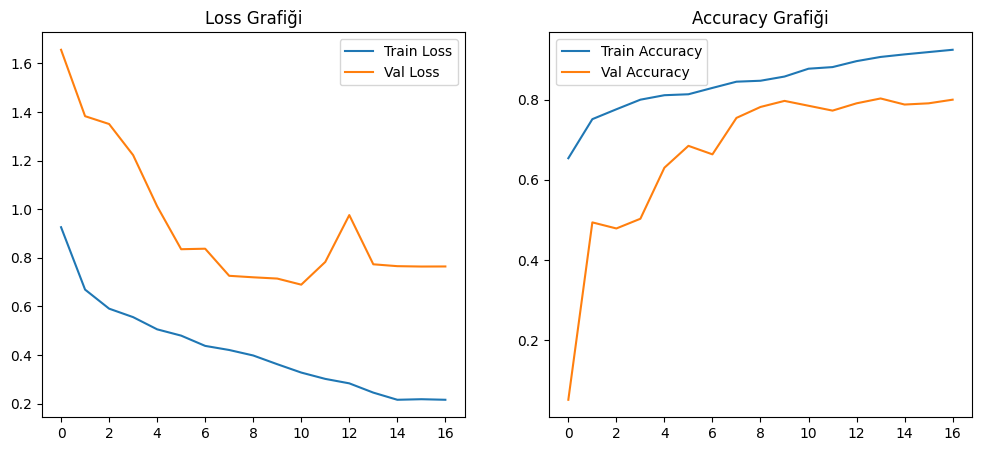

Test Loss: 0.6482 - Test Accuracy: 0.8038


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import layers, models, optimizers, callbacks

IMAGE_DIR = '/content/all_images'
CSV_PATH  = '/content/diabetic-retinopathy-dataset-esma/train.csv'
BATCH_SIZE = 32
EPOCHS = 30
IMG_SIZE = (224, 224)

df = pd.read_csv(CSV_PATH)
df.rename(columns={'id_code': 'image', 'diagnosis': 'level'}, inplace=True)
df['image_path'] = df['image'].apply(lambda x: os.path.join(IMAGE_DIR, x + '.png'))
df['level'] = df['level'].astype(str)

train_val, test = train_test_split(df, test_size=0.1, random_state=42, stratify=df['level'])
train, val = train_test_split(train_val, test_size=0.1, random_state=42, stratify=train_val['level'])

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train,
    x_col='image_path',
    y_col='level',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_gen = val_datagen.flow_from_dataframe(
    val,
    x_col='image_path',
    y_col='level',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)
test_gen = test_datagen.flow_from_dataframe(
    test,
    x_col='image_path',
    y_col='level',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(5, activation='softmax')
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr  = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)

history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=[early_stop, reduce_lr]
)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Grafiği')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy Grafiği')
plt.show()

test_loss, test_acc = model.evaluate(test_gen, verbose=0)
print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_acc:.4f}")
